<a href="https://colab.research.google.com/github/PengJuan-AI/TensorFlow_Study/blob/main/09_SkimLit_nlp_milestone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit 📝
** The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.**

### Original Paper
The paper we're replicating is [a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071).

The model architecture that they use to achieve the best results is here: https://arxiv.org/pdf/1612.05251.pdf

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

## What is the task
What the Skimlit model doing is to transfer a hard-to-read abstract into a easier-to-read one. (many-to-one problem)
* Input -  a sentence in one abstract
* Output - a label

What is going to include in this project:
* Downloading a text dataset.
* Writing a preprocessing function for our text data.
* Setting up multiple modelling experiments _with different levels of embeddings_.
* Building _multimodal model_ to take in different sources of data.
* Finding the most wrong prediction examples.

## Additional

Some motivation!

> Machine Learning Engineer
> 1. Download a paper.
> 2. Implement it.
> 3. Keep doing this until you have skills.
> 4. Machine learning engineering also involves building infrastructure around your model/data preprocessings steps.

## Get helper function

In [1]:
# get helper functions we write before
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-18 00:13:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-18 00:13:53 (98.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import calculate_results helper function
from helper_functions import calculate_results

## Get data

Since we'll be replicating the paper, let's download the dataset they used (PubMed 200k RCT)

Find the data of a paper on Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 24.34 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


PubMed 20k is a subset of PubMed 200k, we experiment on 20k dataset and then scale up to the whole dataset.

The first step should be scan through the dataset (or subsets) to check the format of the dataset. Further we need to write a function to preprocess the dataset so that make it ready for our model.

In [4]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/ # this dataset replace number with @

dev.txt  test.txt  train.txt


In [5]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

**Become One with Data**

> Visualize, visualize, visualize

Read file with Python: https://realpython.com/read-write-files-python/

In [7]:
# Read all lines of target files
def get_lines(filename):
  """
  Reads filename and returns the lines pf text as a list

  Args:
    filename: a string containing the target filepath.

  Return:
    A list of strings with one string per line from the target file.
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [8]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines in the training file
train_lines[:35]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

How do we want our data to look?

```python
# A list of dictory data structure
[{'line_number': 0,
  'target': RESULTS, # or METHODS or OBJECTIVE or BACKGROUND or CONCLUSION
  'text': ...,
  'total_lines': ...,
}]
```

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
def preprocess_text_data(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Take in filename, reads its contents through each line,
  extracting attributes - line_number, target, text and total_line.
  """
  inputlines = get_lines(filename)
  abstract = []
  processed_data = []
  for line in inputlines:
    if line.startswith("###"): # is the first line of an abstract (skip)
      if len(abstract) == 0:
        continue
      else: # comes to another '###' means that it comes to a new abstract, so we need to preprocess the last abstract
        total_line = len(abstract)
        for n,sentence in enumerate(abstract):
          sentence = sentence.strip("\n").split('\t')
          # print(f"Line number is {n}\n {sentence}")
          abstract_dict = {"line_number": n,
                         "target": sentence[0],
                         "text": sentence[1].lower(),
                         "total_line": total_line}
          processed_data.append(abstract_dict)
        # reset the abstract contents
        abstract = []
    # elif line=='\n': # skip
    elif line.isspace():
      continue
    else:
      abstract.append(line)

  return processed_data

In [11]:
%%time
train_samples = preprocess_text_data(data_dir+'train.txt')
val_samples = preprocess_text_data(data_dir+'dev.txt') # dev.txt is another name for validation data
test_samples = preprocess_text_data(data_dir+'test.txt')
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 250 ms, sys: 86.9 ms, total: 337 ms
Wall time: 342 ms


(180028, 30198, 30117)

In [12]:
# try functions in course
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 296 ms, sys: 55 ms, total: 351 ms
Wall time: 360 ms


(180040, 30212, 30135)

In [13]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Turn it into DataFrame to further visualize it.

In [14]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [15]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [16]:
# Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

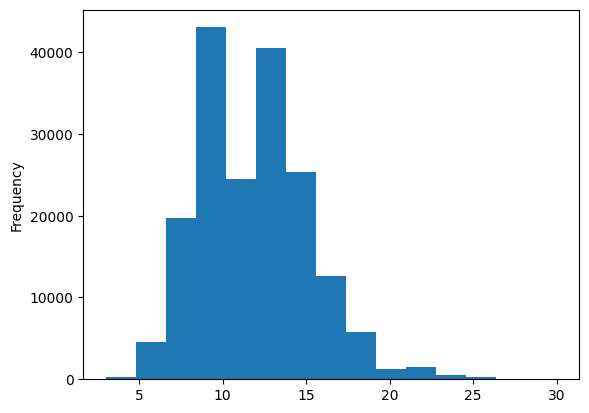

In [17]:
# The length of different lines
train_df.total_lines.plot.hist(bins=15);

Most of the abstracts have total lines between `(5, 18)`.

### Get list of sentences

In [18]:
# Convert abstract text lines into lists
# train_sentences = train_df["text"].to_numpy()
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Make numeric labels (ML models require numeric labels)

### One-hot encoding

In [19]:
# One hot encoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) # tf doesn't support tensorflow sparse matrix format so we set it False
# ordinal_encoder = OrdinalEncoder(dtype='int32')

one_hot_encoder.fit(train_df[["target"]])
train_labels_onehot = one_hot_encoder.transform(train_df[["target"]])
train_labels_onehot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
val_labels_onehot = one_hot_encoder.transform(val_df[["target"]])
test_labels_onehot = one_hot_encoder.transform(test_df[["target"]])

### Ordinal encoding

```python
ordinal_encoder.fit(train_df[["target"]])
train_labels = ordinal_encoder.transform(train_df[["target"]])
train_labels[:10]

# array([[3],
#        [2],
#        [2],
#        [2],
#        [2],
#        [2],
#        [4],
#        [4],
#        [4],
#        [4]], dtype=int32)
```

### Label encoding

In [21]:
from sqlalchemy import Label
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df.target)
val_labels_encoded = label_encoder.transform(val_df.target)
test_labels_encoded = label_encoder.transform(test_df.target)

# check the training labels
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a Series of Experiments

Now we're going to try out a series of experiments and see which one works.

And the first model is the baseline mode. Here we use TF-IDF Multinomial Naive Bayes Classifier.

1. Naive Bayes with TF-IDF encoder
2. Conv1D with token embeddings
3. TensorFlow Hub Pretrained Feature Extractor
4. Conv1D wuth character embeddings
5. Pretrained token embeddings + character embeddings
6. Pretrained token embeddings + character embeddings + positional embeddings

### Model 0 - baseline (Naive Bayes)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
    ])

model_0.fit(train_sentences, train_labels_encoded)
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [24]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [25]:
# compare the preds and true labels using our helper function -> calculate_results()
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

⚠️ **Remider**:

If the `train_sentences` is `numpy` type, then error:
```
AttributeError: 'numpy.ndarray' object has no attribute 'lower'
```
After change to `list` type, it works.


## Preparing text to numeric format for deep sequence model

Create vectorization and embedding layers.



In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long is each sentence on average
# Need to define the output length in textorization
sentence_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_len = np.mean(sentence_lens)
avg_sentence_len

26.338269273494777

So the average length of sentence in the training data set is 26

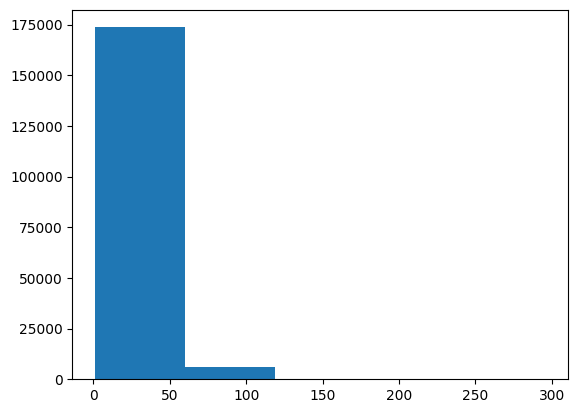

In [28]:
# The distribution
import matplotlib.pyplot as plt
plt.hist(sentence_lens, bins=5);

In [29]:
# How long of a sentence length cover 95% of examples?
out_seq_len = int(np.percentile(sentence_lens, 95))
out_seq_len

55

In [30]:
# The maximum sequence length
max(sentence_lens)

296

> 💡 The steps here help us define the `output_sequence_length` so that it can cover the majority of our training samples.

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

> "I love TensorFlow" -> [0, 1, 2]
> ```
> I = 1
> love = 2
> TensorFlow = 3
> ```

In [31]:
# How many words in our dataset (taken from the paper)
max_vocab = 68000

# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_vocab,
                                    output_sequence_length=out_seq_len)


In [32]:
# Adapt to text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [33]:
# Test out text vectorizer on random sentences
import random
random_sentence = random.choice(train_sentences)
print(f"Text:\n {random_sentence}")
print(f"Length of text: {len(random_sentence.split())}\n")
print(f"Vectorized text:\n {text_vectorizer([random_sentence])}")

Text:
 all cattle were ear-tagged , treated with diminazene diaceturate ( da ) and those in regimens @-@ received monthly graded rap .
Length of text: 22

Vectorized text:
 [[   62  6309     9 59093   172     7 31701 39672  2977     3   125     5
    952    80  1097  3013 10192     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [34]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words: {rct_20k_text_vocab[:5]}")
print(f"Most common words: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Most common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
# get all the parameters of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [36]:
from tensorflow.keras.layers import Embedding

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # all vocab in training dataset
                               output_dim=128, # the larger output dim, the longer training time
                               mask_zero=True, # the benefit is saving space
                               name="token_embedding")

`mask_zero=True` means that if there are lost of zeroes in inputs, the embedding layer will mask it so that improve computing efficiency.

In [37]:
# Show example embedding
print(f"Sentence before vectorization: \n {random_sentence}")
vectorized_sentence = text_vectorizer([random_sentence])
print(f"After vectorization before embedding:\n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization: 
 all cattle were ear-tagged , treated with diminazene diaceturate ( da ) and those in regimens @-@ received monthly graded rap .
After vectorization before embedding:
 [[   62  6309     9 59093   172     7 31701 39672  2977     3   125     5
    952    80  1097  3013 10192     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
 [[[ 0.00198573 -0.00765151 -0.00736092 ... -0.03147845 -0.02108963
    0.04023762]
  [-0.03043673 -0.03436925 -0.00029727 ... -0.00186272  0.04405091
    0.00802635]
  [-0.00734006 -0.01062737 -0.01148904 ...  0.02566249  0.01740395
   -0.02945696]
  ...
  [-0.02083162  0.03269492 -0.00669986 ... -0.0279091  -0.01687013
   -0.01941784]
  [-0.02083162  0.03269492 -0.00669986 ... -0.0279091  -0.01687013
   -0.01941784]
  [-0.0208

Each words in vectorized sentence (55 in total) is represented by a 128-dim vector.

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, see resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [38]:
# Turn our data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_onehot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_onehot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_onehot))

In [39]:
# Turn into prefetch datasets
# Here we want the model to learn the order of inputs so we don't need to shuffle the datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1 - Conv1D

In [40]:
from tensorflow.keras import layers
# model_1 = tf.keras.Sequential([
#     text_vectorizer(),
#     token_embed(),
#     layers.Conv1D(),
#     layers.AveragePooling1D(),
#     layers.Dense(5)
# ])
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x) # we are working on multiclasses classification - softmax
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [41]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                             

In [42]:
# Here we have 5627 batches (still large)
len(train_dataset), len(train_sentences)/32

(5627, 5626.25)

In [43]:
model_1_history = model_1.fit(train_dataset, epochs=5,
                              steps_per_epoch=len(train_dataset),
                              # steps_per_epoch=int(0.1*len(train_dataset)), # we train on 10% of training data to get results quicker so we can check what is going well faster.
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/5
5627/5627 [==============================] - 395s 70ms/step - loss: 0.5508 - accuracy: 0.7968 - val_loss: 0.4875 - val_accuracy: 0.8228
Epoch 2/5
5627/5627 [==============================] - 393s 70ms/step - loss: 0.3598 - accuracy: 0.8721 - val_loss: 0.5138 - val_accuracy: 0.8225
Epoch 3/5
5627/5627 [==============================] - 393s 70ms/step - loss: 0.2151 - accuracy: 0.9302 - val_loss: 0.6043 - val_accuracy: 0.8085
Epoch 4/5
5627/5627 [==============================] - 381s 68ms/step - loss: 0.1112 - accuracy: 0.9675 - val_loss: 0.7394 - val_accuracy: 0.8015
Epoch 5/5
5627/5627 [==============================] - 410s 73ms/step - loss: 0.0581 - accuracy: 0.9844 - val_loss: 0.8734 - val_accuracy: 0.7962


Training process for 5 epoch:
```
Epoch 1/5
5627/5627 [==============================] - 395s 70ms/step - loss: 0.5508 - accuracy: 0.7968 - val_loss: 0.4875 - val_accuracy: 0.8228
Epoch 2/5
5627/5627 [==============================] - 393s 70ms/step - loss: 0.3598 - accuracy: 0.8721 - val_loss: 0.5138 - val_accuracy: 0.8225
Epoch 3/5
5627/5627 [==============================] - 393s 70ms/step - loss: 0.2151 - accuracy: 0.9302 - val_loss: 0.6043 - val_accuracy: 0.8085
Epoch 4/5
5627/5627 [==============================] - 381s 68ms/step - loss: 0.1112 - accuracy: 0.9675 - val_loss: 0.7394 - val_accuracy: 0.8015
Epoch 5/5
5627/5627 [==============================] - 410s 73ms/step - loss: 0.0581 - accuracy: 0.9844 - val_loss: 0.8734 - val_accuracy: 0.7962
```

In [44]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.8991 - accuracy: 0.7947


[0.8990655541419983, 0.7946511507034302]

In [45]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 4s 5ms/step


(array([[8.0848920e-01, 1.4383736e-01, 2.3644911e-02, 2.0548189e-02,
         3.4802409e-03],
        [6.0596240e-01, 1.7793642e-02, 9.7530366e-09, 3.7624362e-01,
         3.6271382e-07],
        [6.5723856e-05, 5.1268111e-05, 3.9899983e-10, 9.9988288e-01,
         6.6556121e-09],
        ...,
        [1.5413663e-09, 2.0147159e-09, 1.0775945e-03, 3.8620474e-08,
         9.9892235e-01],
        [2.5245862e-04, 9.9112976e-01, 1.5007122e-05, 1.6297885e-06,
         8.6011039e-03],
        [3.7682989e-07, 9.9999952e-01, 3.1085207e-08, 2.0155051e-08,
         1.5439485e-07]], dtype=float32),
 (30212, 5))

In [46]:
# convert pred_probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 79.46511320005297,
 'precision': 0.7926879260877197,
 'recall': 0.7946511320005296,
 'f1': 0.7927004130055443}

In [49]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

🎉 Great! We beat the baseline using only one convolutional layer.

## Model 2 - Feature extraction with pretrained token embeddings

In the original paper, the authors used [GloVe embeddings](https://nlp.stanford.edu/projects/glove/), we could use it for our `model_2`. (extension)

However, we are going to use more recent version of pretrained word embedding -- [universal sentence encoder(USE)](https://tfhub.dev/google/universal-sentence-encoder/4).

Or, you can check more pretrained models on [Huggingface](https://huggingface.co/models).

When you're using transfer learning, we would want to find the latest version of some pretrained feature extractors/embeddings.

----
We'll keep the pretrained embeddings frozen (by setting `trainable=False`) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

In [50]:
# Download pretrained Tensorflow Hub USE
import tensorflow_hub as hub
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable=False,
                                 name="universal_sentence_encoder") # output is 512 dimensional vector

In [52]:
# Test out the pretrained embedding on a random sentence
# We don't need to vectorize sentences using USE embedding
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = embedding_layer([random_train_sentence])
print(f"Sentence after embeded:\n {use_embedded_sentence[0][:30]}") # first 30
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")


Random sentence:
 the response rate was @ % with nivolumab versus @ % with docetaxel ( p = @ ) .
Sentence after embeded:
 [ 0.01381422 -0.07788073  0.00224727 -0.0500415  -0.02583176  0.03453026
  0.03104751 -0.06666333  0.05171972  0.03999669  0.00215903  0.06156719
  0.00516985 -0.00302238  0.01961534 -0.00388749  0.06165432 -0.00642532
  0.04615     0.01207109  0.08077908 -0.03281293  0.01646825  0.02228799
 -0.03198744  0.01979592 -0.06054161  0.0290057  -0.08539628  0.05554584]
Length of sentence embedding: 512


In [57]:
# Create model 2
# wrong way: inputs = layers.Input(shape=(1,), dtype=tf.string)
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

❓Question: Why not use convolution layer?

In [58]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [61]:
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 11ms/step - loss: 0.9191 - accuracy: 0.6477 - val_loss: 0.7978 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7684 - accuracy: 0.7018 - val_loss: 0.7542 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7508 - accuracy: 0.7124 - val_loss: 0.7365 - val_accuracy: 0.7171


`model_2` is training faster than `model_1`. That's because `model_2` doesn't have to train the embedding layer since we set `trainable=False`, while in `model_1`, we have to train our own embedding layer.

In [62]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.7382 - accuracy: 0.7156


[0.7382416725158691, 0.7156096696853638]

In [64]:
model_2_preds = tf.argmax(model_2.predict(valid_dataset), axis=1)
model_2_preds[:10]

945/945 [==============================] - 8s 9ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 4, 2, 2, 2, 4, 1])>

In [65]:
# Calculate results from TF hub pretrained embedding
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.5609691513306,
 'precision': 0.7157621058131338,
 'recall': 0.715609691513306,
 'f1': 0.7128240371038443}

In [66]:
 baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Well, it seems like `model_2` does not outperform the baseline. It's okay, we will keep doing experiments.

## Model 3 - Conv1D with Character embeddings.